In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
!ls /drive/My\ Drive/Medium

dev-v2.0.json  train-v2.0.json	utils_squad_evaluate.py  utils_squad.py


In [ ]:
import sys
sys.path.append('/drive/My Drive/Medium')

In [ ]:
from __future__ import absolute_import, division, print_function

import json
import logging
import math
import collections
from io import open

from pytorch_transformers.tokenization_bert import BasicTokenizer, whitespace_tokenize

In [ ]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
input_file = '/drive/My Drive/Medium/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [ ]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [ ]:
examples = examples[0:len(examples)//5]

In [ ]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [ ]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
24560,56f8abee9b226e1400dd0dbf,What do the plants tend to form at higher alti...,"[At, these, higher, altitudes,, the, plants, t...",isolated cushions,9,10,False
24561,56f8abee9b226e1400dd0dc0,Ranunculus glacialis have been recorded to hav...,"[At, these, higher, altitudes,, the, plants, t...","above 4,000 m",22,24,False
24562,56f8abee9b226e1400dd0dc1,What is Eritrichium nanum commonly known as?,"[At, these, higher, altitudes,, the, plants, t...",the King of the Alps,41,45,False
24563,56f8abee9b226e1400dd0dc2,What is the best known of the alpine plants?,"[At, these, higher, altitudes,, the, plants, t...",Edelweiss,77,77,False


In [ ]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No answer found'))

In [ ]:
print_squad_sample(train_data)

CONTEXT: 
In 1989, the first ISPs were established in Australia and the United States. In
Brookline, Massachusetts, The World became the first commercial ISP in the US. Its first
customer was served in November 1989.
QUESTION:                                                                                            ANSWER:
Where were the first isps established?                                                               Australia and the United States
where was the first commercial isp in the us located?                                                Brookline, Massachusetts
when was the first commercial isp customer served?                                                   November 1989
when were the first commercial isps established?                                                     1989
what was the name of the first commercial isp in the us?                                             The World
Where was the first ISP S established in 1999?                                     

In [ ]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
3927,56cfad77234ae51400d9be61,Who was the founder of the New York Post?,"[More, than, 200, newspapers, and, 350, consum...",Alexander Hamilton,85,86,False,144,41
11057,56de58e4cffd8e1900b4b82e,What does TDM stand for?,"[European, Travel, Commission, divides, the, E...",Tourism Decision Metrics,11,13,False,24,24
22333,5ad4b4fb5b96ef001a109e16,When was slavs used for the Yugoslavia and Mon...,"[The, word, ""Slavs"", was, used, in, the, natio...",,-1,-1,True,28,61
21618,5ad40114604f3c001a3ffd02,What aren't the effigies made of?,"[Later, wax, effigies, include, a, likeness, o...",,-1,-1,True,58,33
17782,56e15399cd28a01900c677dc,"Along with Donald O'Connor and Bing Crosby, wi...","[When, Pasternak, stopped, producing, Durbin's...",Bing Crosby,38,39,False,75,75


In [ ]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.77604266584814%


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [ ]:
cached_features_file = '/drive/My Drive/Medium/cache_train'

In [ ]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [ ]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
import glob
checkpoints = sorted(glob.glob('/drive/My Drive/Medium/checkpoint*-[0-9]*'))

In [ ]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [ ]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/drive/My Drive/Medium/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:15<00:00, 27929682.46B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0030,  0.0139, -0.0027,  ..., -0.0030,  0.0046,  0.0381],
        [ 0.0084,  0.0038,  0.0357,  ..., -0.0305,  0.0054,  0.0135]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [ ]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 500 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/drive/My Drive/Medium/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

      

Iteration:   0%|          | 0/1754 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 28079
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 1754


/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  29%|██▊       | 500/1754 [06:46<17:00,  1.23it/s]

Train loss: 2.043099732398987



Iteration:  29%|██▊       | 501/1754 [06:48<28:55,  1.39s/it]

Saving model checkpoint to /drive/My Drive/Medium/checkpoint-500



Iteration:  57%|█████▋    | 1000/1754 [13:34<10:13,  1.23it/s]

Train loss: 1.7040860281586647



Iteration:  57%|█████▋    | 1001/1754 [13:37<18:55,  1.51s/it]

Saving model checkpoint to /drive/My Drive/Medium/checkpoint-1000



Iteration:  86%|████████▌ | 1500/1754 [20:22<03:26,  1.23it/s]

Train loss: 1.5347209525108338



Iteration:  86%|████████▌ | 1501/1754 [20:25<05:54,  1.40s/it]

Saving model checkpoint to /drive/My Drive/Medium/checkpoint-1500



Epoch: 100%|██████████| 1/1 [23:51<00:00, 1431.03s/it]


In [ ]:
output_dir = '/drive/My Drive/Medium/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

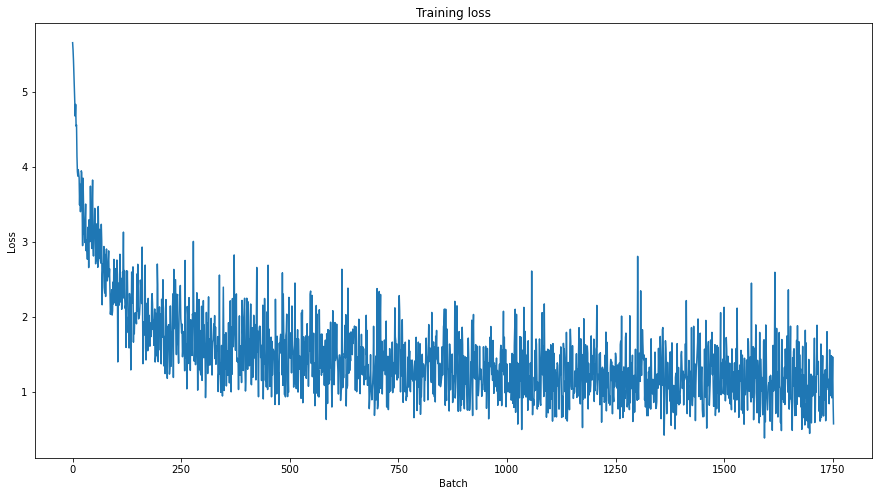

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [ ]:
input_file = '/drive/My Drive/Medium/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/drive/My Drive/Medium/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [ ]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/drive/My Drive/Medium//dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/drive/My Drive/Medium/predictions.json"
  output_nbest_file = "/drive/My Drive/Medium/nbest_predictions.json"
  output_null_log_odds_file = "/drive/My Drive/Medium/null_odds.json"
  output_dir = "/drive/My Drive/Medium/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer)

Evaluating:   0%|          | 0/850 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16


Evaluating: 100%|██████████| 850/850 [03:45<00:00,  3.76it/s]


{
  "exact": 57.702349869451695,
  "f1": 60.588111288370555,
  "total": 11873,
  "HasAns_exact": 54.35222672064777,
  "HasAns_f1": 60.13202519008455,
  "HasAns_total": 5928,
  "NoAns_exact": 61.042893187552565,
  "NoAns_f1": 61.042893187552565,
  "NoAns_total": 5945,
  "best_exact": 58.40141497515371,
  "best_exact_thresh": -0.832545280456543,
  "best_f1": 60.92350469970059,
  "best_f1_thresh": -0.8324878215789795
}


In [ ]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 57.702349869451695}, {'f1': 60.588111288370555}, {'total': 11873}, {'HasAns_exact': 54.35222672064777}, {'HasAns_f1': 60.13202519008455}, {'HasAns_total': 5928}, {'NoAns_exact': 61.042893187552565}, {'NoAns_f1': 61.042893187552565}, {'NoAns_total': 5945}, {'best_exact': 58.40141497515371}, {'best_exact_thresh': -0.832545280456543}, {'best_f1': 60.92350469970059}, {'best_f1_thresh': -0.8324878215789795}]


**Evaluate on any text**

In [ ]:
val_data = pd.DataFrame.from_records([vars(example) for example in val_examples])
val_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56ddde6b9a695914005b9628,In what country is Normandy located?,"[The, Normans, (Norman:, Nourmands;, French:, ...",None,None,None,False
1,56ddde6b9a695914005b9629,When were the Normans in Normandy?,"[The, Normans, (Norman:, Nourmands;, French:, ...",None,None,None,False
2,56ddde6b9a695914005b962a,From which countries did the Norse originate?,"[The, Normans, (Norman:, Nourmands;, French:, ...",None,None,None,False
3,56ddde6b9a695914005b962b,Who was the Norse leader?,"[The, Normans, (Norman:, Nourmands;, French:, ...",None,None,None,False
4,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,"[The, Normans, (Norman:, Nourmands;, French:, ...",None,None,None,False


In [ ]:
val_sample = val_data.sample(frac=1).head(1)
context = val_sample.doc_tokens.values
val_data[val_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
11524,57373f80c3c5551400e51e8f,When were the shortcomings of Aristotle's phys...,"[The, shortcomings, of, Aristotelian, physics,...",None,None,None,False
11525,57373f80c3c5551400e51e90,Whose work corrected Aristotle's physics in t...,"[The, shortcomings, of, Aristotelian, physics,...",None,None,None,False
11526,57373f80c3c5551400e51e91,What did objects in forced motion contain acco...,"[The, shortcomings, of, Aristotelian, physics,...",None,None,None,False
11527,57373f80c3c5551400e51e92,Who experimented by rolling stones and canonba...,"[The, shortcomings, of, Aristotelian, physics,...",None,None,None,False
11528,57373f80c3c5551400e51e93,What force acted on bodies to retard their vel...,"[The, shortcomings, of, Aristotelian, physics,...",None,None,None,False
11529,5ad26103d7d075001a428fec,The shortcomings of Aristotelian physics would...,"[The, shortcomings, of, Aristotelian, physics,...",None,None,None,False
11530,5ad26103d7d075001a428fed,Who was influenced by early Medieval ideas?,"[The, shortcomings, of, Aristotelian, physics,...",None,None,None,False
11531,5ad26103d7d075001a428fee,Who constructed an experiment where stones and...,"[The, shortcomings, of, Aristotelian, physics,...",None,None,None,False
11532,5ad26103d7d075001a428fef,Who argued that objects retain their velocity ...,"[The, shortcomings, of, Aristotelian, physics,...",None,None,None,False


In [ ]:
import random
def print_squad_sample(val_data, pred_loc, line_length=14, separator_length=120):
  sample = val_data.sample(frac=1).head(1)
  pred_data = pd.read_json(pred_loc, orient="index")
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = val_data[val_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'PREDICTED:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = pred_data[pred_data.index == row.qas_id][0][0]
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No answer found'))

In [ ]:
print_squad_sample(val_data, "/drive/MyDrive/Medium/predictions.json")

CONTEXT: 
In the meantime, on August 1, 1774, an experiment conducted by the British clergyman
Joseph Priestley focused sunlight on mercuric oxide (HgO) inside a glass tube, which liberated
a gas he named "dephlogisticated air". He noted that candles burned brighter in the
gas and that a mouse was more active and lived longer while breathing it.
After breathing the gas himself, he wrote: "The feeling of it to my lungs
was not sensibly different from that of common air, but I fancied that my
breast felt peculiarly light and easy for some time afterwards." Priestley published his findings
in 1775 in a paper titled "An Account of Further Discoveries in Air" which
was included in the second volume of his book titled Experiments and Observations on
Different Kinds of Air. Because he published his findings first, Priestley is usually given
priority in the discovery.
QUESTION:                                                                                            PREDICTED:
"An Account of 

In [ ]:
print_squad_sample(val_data, "/drive/MyDrive/Medium/predictions.json")

CONTEXT: 
There is evidence that there have been significant changes in Amazon rainforest vegetation over
the last 21,000 years through the Last Glacial Maximum (LGM) and subsequent deglaciation. Analyses
of sediment deposits from Amazon basin paleolakes and from the Amazon Fan indicate that
rainfall in the basin during the LGM was lower than for the present, and
this was almost certainly associated with reduced moist tropical vegetation cover in the basin.
There is debate, however, over how extensive this reduction was. Some scientists argue that
the rainforest was reduced to small, isolated refugia separated by open forest and grassland;
other scientists argue that the rainforest remained largely intact but extended less far to
the north, south, and east than is seen today. This debate has proved difficult
to resolve because the practical limitations of working in the rainforest mean that data
sampling is biased away from the center of the Amazon basin, and both explanations
are reas

In [ ]:
print_squad_sample(val_data, "/drive/MyDrive/Medium/predictions.json")

CONTEXT: 
As Fortnow & Homer (2003) point out, the beginning of systematic studies in computational
complexity is attributed to the seminal paper "On the Computational Complexity of Algorithms" by
Juris Hartmanis and Richard Stearns (1965), which laid out the definitions of time and
space complexity and proved the hierarchy theorems. Also, in 1965 Edmonds defined a "good"
algorithm as one with running time bounded by a polynomial of the input size.
QUESTION:                                                                                            PREDICTED:
What paper is commonly considered the bellwether ushering in systematic studies computational complexity?  No answer found
What individuals were responsible for authoring "On the Computational Complexity of Algorithms"?     Juris Hartmanis and Richard Stearns
In what year was Hatmanis and Stearn's seminal work in computational complexity received?            1965
What complex measurements were defined by "On the Computational Compl

In [ ]:
print_squad_sample(val_data, "/drive/MyDrive/Medium/predictions.json")

CONTEXT: 
Although the European Union does not have a codified constitution, like every political body
it has laws which "constitute" its basic governance structure. The EU's primary constitutional sources
are the Treaty on European Union (TEU) and the Treaty on the Functioning of
the European Union (TFEU), which have been agreed or adhered to among the governments
of all 28 member states. The Treaties establish the EU's institutions, list their powers
and responsibilities, and explain the areas in which the EU can legislate with Directives
or Regulations. The European Commission has the initiative to propose legislation. During the ordinary
legislative procedure, the Council (which are ministers from member state governments) and the European
Parliament (elected by citizens) can make amendments and must give their consent for laws
to pass. The Commission oversees departments and various agencies that execute or enforce EU
law. The "European Council" (rather than the Council, made up o

In [ ]:
print_squad_sample(val_data, "/drive/MyDrive/Medium/predictions.json")

CONTEXT: 
Southern California includes the heavily built-up urban area stretching along the Pacific coast from
Ventura, through the Greater Los Angeles Area and the Inland Empire, and down to
Greater San Diego. Southern California's population encompasses seven metropolitan areas, or MSAs: the Los
Angeles metropolitan area, consisting of Los Angeles and Orange counties; the Inland Empire, consisting
of Riverside and San Bernardino counties; the San Diego metropolitan area; the Oxnard–Thousand Oaks–Ventura
metropolitan area; the Santa Barbara metro area; the San Luis Obispo metropolitan area; and
the El Centro area. Out of these, three are heavy populated areas: the Los
Angeles area with over 12 million inhabitants, the Riverside-San Bernardino area with over four
million inhabitants, and the San Diego area with over 3 million inhabitants. For CSA
metropolitan purposes, the five counties of Los Angeles, Orange, Riverside, San Bernardino, and Ventura
are all combined to make up the Great